# Import packages

In [1]:
# Run this if running in Google Collab
# Mount google drive if running from Google Collab
from google.colab import drive
drive.mount('/content/drive')

# Set current directory if running from Google Collab
import os
os.chdir('/content/drive/My Drive/Carbon_price_prediction/Workspace/Data')

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, \
                            r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, ElasticNetCV

import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Custom functions

In [2]:
def keyword_features_preprocessing(df, d_Y, d_control_variables,
                                   nr_lags, ma_window, standardization=False,
                                   min_obs = 0,
                                   concat_all = True, same_day_info=False):

    """
    Returns the preprocessed keyword features concatenated with the control
     variables.

    Parameters:
            df (pandas DataFrame): the keyword feature values
            d_Y (pandas DataFrame): Dependant variable
            d_control_variables (pandas DataFrame): Control variables
            nr_lags (int): Number of lags for the keyword features to include
            ma_window (int): Moving average window size
            standardization (bool): Whether to standardize the features or not
            min_obs (int): Minimum number of observations for a keyword

    Returns:
            lag_X (pandas DataFrame): The feature matrix for the regression
    """

    # Drop columns where nr of days with observation < min_obs
    df = df.loc[ :, df.astype(bool).sum(axis=0) >= min_obs ]
    # Create moving average of scores
    df = df.rolling(ma_window, min_periods=1).mean()

    # Check if variable has any variation
    if standardization:
        for col in df.columns:
            if np.nanstd(df[col]) > 0:
                df[col]=(df[col]-np.nanmean(df[col]))/np.nanstd(df[col])
            else:
                df = df.drop(col, 1)
    
    # get keyword feature column names
    keyword_colnames = df.columns

    if d_control_variables is None: # Ha adtunk meg kontroll változót akkor összefűzi a keyword feature-el, egyébként csak az utóbbit adja vissza
        X = df.loc[ d_Y.index, : ]
    else:
        X = d_control_variables.copy()
        X = pd.concat( [ X, df.loc[ X.index, : ] ], axis = 1 )
        X[ 'carbon_price' ] = d_Y

    lag_X = X.shift( 1 )
    if same_day_info:
        lag_X[keyword_colnames] = X[keyword_colnames].copy()
    lag_X.columns = [ str( col ) + f'_lag{ 1 }' for col in lag_X.columns ]
    if concat_all: # Ha a concat_all True, minden lag változót összefűz 1-től n-ig, ha False csak az 1-et és az n-ediket
        for lag in range( 2, ( nr_lags + 1 ) ):
            lag_data = X.shift( lag )
            lag_data.columns = [ str( col ) + f'_lag{ lag }' for col in lag_data.columns ]
            lag_X = pd.concat( [ lag_X, lag_data ], axis = 1 )
    else:
        lag_data = X.shift( nr_lags )
        lag_data.columns = [ str( col ) + f'_lag{ nr_lags }' for col in lag_data.columns ]
        lag_X = pd.concat( [ lag_X, lag_data ], axis = 1 )

    lag_X = sm.add_constant( lag_X )

    return lag_X

In [3]:
def control_var_preprocessing(d_Y, d_control_variables, nr_lags, concat_all = True):

    """
    Returns the preprocessed control variables ready for regression

    Parameters:
            d_Y (pandas DataFrame): Dependant variable
            d_control_variables (pandas DataFrame): Control variables
            nr_lags (int): Number of lags for the control variables to include

    Returns:
            lag_X (pandas DataFrame): The feature matrix for the regression
    """

    X = d_control_variables.copy()

    X[ 'carbon_price' ] = d_Y

    lag_X = X.shift( 1 )
    lag_X.columns = [ str( col ) + f'_lag{ 1 }' for col in lag_X.columns ]
    if concat_all:
        for lag in range( 2, ( nr_lags + 1 ) ):
            lag_data = X.shift( lag )
            lag_data.columns = [ str( col ) + f'_lag{ lag }' for col in lag_data.columns ]
            lag_X = pd.concat( [ lag_X, lag_data ], axis = 1 )
    else:
        lag_data = X.shift( nr_lags )
        lag_data.columns = [ str( col ) + f'_lag{ nr_lags }' for col in lag_data.columns ]
        lag_X = pd.concat( [ lag_X, lag_data ], axis = 1 )
        
    lag_X = sm.add_constant( lag_X )

    return lag_X

In [4]:
def train_test_split(df, test_window):

    """
    Returns train-test split of the data.

    Parameters:
            df (pandas DataFrame): The dataframe to be splitted into train and test
            test_window (int): Test window size
    Returns:
            train (pandas DataFrame): Values for the training period
            test (pandas DataFrame): Values for the test period
    """

    train = df.iloc[:(len(df)-test_window),]
    test = df.iloc[-test_window:,]

    return train, test

In [5]:
def robustness_check_workflow(X, d_Y, d_control_variables, control_X, nr_lags, ma_window,
                              standardization, min_obs, test_window, model_type,
                              pca_components, loss_measure='MAPE'):
    
    # Feature preprocessing
    if X is not None:
        tf_idf_X = keyword_features_preprocessing(X, d_Y, d_control_variables,
                                                nr_lags, ma_window,
                                                standardization, min_obs)
    
    # Control variable preprocessing
    control_X = control_var_preprocessing(d_Y, d_control_variables, nr_lags)
    
    # Train-test split
    d_Y_train, d_Y_test = train_test_split(d_Y, test_window)
    if X is not None:
        tf_idf_X_train, tf_idf_X_test = train_test_split(tf_idf_X, test_window)
    else:
        tf_idf_X_train, tf_idf_X_test = train_test_split(control_X, test_window)
    tf_idf_X_test.fillna(0, inplace=True)
    tf_idf_X_train.fillna(0, inplace=True)

    control_X_train, control_X_test = train_test_split(control_X, test_window)
    control_X_test.fillna(0, inplace=True)
    control_X_train.fillna(0, inplace=True)

    if model_type == 'control':
        X_train = control_X_train.copy()
        X_test = control_X_test.copy()
    elif model_type == 'pca':
        pca = PCA(n_components=pca_components)
        # selected_cols = [i for i in control_X_train.columns if any([j in i for j in control_var_names + ['carbon_price', 'const']])]
        # pca_X_train = pca.fit_transform(tf_idf_X_train.drop(columns=selected_cols).fillna(0))
        # pca_X_test = pca.transform(tf_idf_X_test.drop(columns=selected_cols).fillna(0))
        # X_train = pd.concat([control_X_train,
        #                  pd.DataFrame(pca_X_train, index=control_X_train.index,
        #                               columns=[f'PCA{i + 1}' for i in range(pca_components)])], axis = 1)
        # X_test = pd.concat([control_X_test,
        #                 pd.DataFrame(pca_X_test, index=control_X_test.index,
        #                              columns=[f'PCA{i + 1}' for i in range(pca_components)])], axis = 1)
        
        X_train = pca.fit_transform(tf_idf_X_train.fillna(0))
        X_test = pca.transform(tf_idf_X_test.fillna(0))
    else:
        X_train = tf_idf_X_train.copy()
        X_test = tf_idf_X_test.copy()

    # Model training
    if model_type == 'elasticnet':
        elastic_net_cv = 5
        model = ElasticNetCV(cv=elastic_net_cv, random_state=0, fit_intercept=False,
                            l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                            alphas=[0.001, 0.003, 0.005, 0.007, 0.009, 0.0095, 0.01])
        model.fit(X_train, d_Y_train)

    elif model_type == 'control':
        model_pre = sm.OLS(d_Y_train, X_train, missing = 'drop' )
        model = model_pre.fit()

    elif model_type == 'ols':
        model_pre = sm.OLS(d_Y_train, X_train, missing = 'drop' )
        model = model_pre.fit()

    elif model_type == 'stepwise':
        stepwise_selected_features = stepwise_selection(X_train.drop(columns=['const']),
                                                d_Y_train)
        model_pre = sm.OLS(d_Y_train, X_train[stepwise_selected_features], missing = 'drop' )
        model = model_pre.fit()
        X_test = X_test[stepwise_selected_features]

    elif model_type == 'pca':
        model_pre = sm.OLS(d_Y_train, X_train, missing = 'drop' )
        model = model_pre.fit()

    elif model_type == 'mlp':
        callback = EarlyStopping(patience=100, restore_best_weights=True)
        input = Input(shape=(X_train.shape[1]))
        x = Dense(64, activation='relu')(input)
        x = Dropout(0.2)(x)
        output = Dense(1)(x)
        model = keras.Model(input, output)
        model.compile(optimizer='sgd', loss='mean_absolute_error')
        model.fit(x=X_train, y=d_Y_train, batch_size=X_train.shape[0],
                  validation_split=0.1, epochs=4000,
                  shuffle=False, callbacks=[callback], verbose=0)


    # Validation
    y_pred = model.predict(X_test)
    if loss_measure == 'MAPE':
        return mean_absolute_percentage_error(d_Y_test, y_pred)
    elif loss_measure == 'MAPE (scaled)':
        return mean_absolute_percentage_error(d_Y_test * 100, y_pred * 100)
    elif loss_measure == 'RMSE':
        return mean_squared_error(d_Y_test, y_pred, squared=False)
    elif loss_measure == 'MAE':
        return mean_absolute_error(d_Y_test, y_pred)
    elif loss_measure == 'R2':
        return r2_score(d_Y_test, y_pred)

In [6]:
def stepwise_selection(X, y,
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=False):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]])), missing='drop').fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            best_feature = excluded[best_feature]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included])), missing='drop').fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature = included[worst_feature]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Parameters

In [7]:
nr_lags = 3
ma_window = 1
tf_idf_ma_window = 1
standardization = True
test_window = 50
min_obs = 1
pca_components = 1
control_var_names = ['oil_price', 'gas_price', 'stock_price',
                    'energy_price', 'coal_price']

old_keywords = False
keyword_generation = 'old' if old_keywords else 'new'

methodology = 'tf_idf' # 'tf_idf' or 'bag_of_words'
data_source = 'gdelt' # 'gdelt'
glossary_source = 'lemmatized_custom' # 'BBC' or 'IPCC' or 'custom' or 'lemmatized_custom' or 'lemmatized_grouped_custom'
version = '' # 'new' or '' for old (in case of BBC), otherwise use ''
loss_measure = 'RMSE' #'RMSE' or 'MAPE' or 'MAE' or 'MAPE (scaled)' or 'R2'
loss_measure_control_normalization = False
interaction_terms = False
volatility_prediction = True

# Data import

## Dependant variable and control variables

In [ ]:
predictors = pd.read_csv( "./new_data/new_merged_dataset.csv", index_col=0,
                         parse_dates=True, dayfirst=True)
predictors.index.name = 'date'
predictors.head()

,carbon_price,oil_price,energy_price,gas_price,coal_price,stock_price,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,6.12,56.82,NaN,NaN,NaN,363.18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,5.43,55.47,NaN,49.45,82.50,365.71,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,5.72,56.46,NaN,50.68,84.20,365.26,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,5.29,56.89,NaN,50.69,85.75,365.64,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,5.50,57.10,NaN,49.77,84.75,365.45,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(predictors)

1277

In [ ]:
predictors.tail(7)

,carbon_price,oil_price,energy_price,gas_price,coal_price,stock_price,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
date,,,,,,,,,,,,,,,,,,,,,
2021-12-02,79.86,69.67,2301.29,242.09,124.25,465.44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03,78.25,69.88,2252.06,228.90,121.50,462.77,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-06,81.25,73.08,2273.25,230.08,122.20,468.71,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-07,84.91,75.44,2358.74,243.98,129.10,480.18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-08,88.88,75.82,2351.98,260.33,134.55,477.36,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-09,80.20,74.42,2352.41,256.11,134.90,476.99,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-10,83.73,75.15,2303.82,268.80,134.90,475.56,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13/12/2021,82.12


In [ ]:
predictors.head(21)

,carbon_price,oil_price,energy_price,gas_price,coal_price,stock_price,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,6.12,56.82,NaN,NaN,NaN,363.18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,5.43,55.47,NaN,49.45,82.50,365.71,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,5.72,56.46,NaN,50.68,84.20,365.26,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,5.29,56.89,NaN,50.69,85.75,365.64,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,5.50,57.10,NaN,49.77,84.75,365.45,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,5.27,54.94,NaN,51.89,84.05,363.67,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,5.51,53.64,NaN,54.53,86.40,364.07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,5.52,55.10,NaN,55.99,88.70,364.90,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,5.40,56.01,NaN,55.93,88.60,362.51,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Keyword features

In [ ]:
tf_idf = pd.read_csv( f'{methodology}_{data_source}_{glossary_source}_{version}keywords.csv',
                     index_col=0, parse_dates=True)
tf_idf.index.name = 'date'

In [ ]:
tf_idf.head(7)

,ghg,climate,sustainability,sustainable,environment,ets,coal,gas,oil,crude,...,gas heating,gas turbine,fossil fuel,nuclear power,nuclear plant,nuclear energy,clean energy,green energy,emission trading system,emission trading scheme
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,1.095514,0.0,0.000000,0.708675,0.0,0.000000,1.42884,1.429732,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,0.0,0.691192,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,0.0,0.000000,0.0,0.000000,1.417349,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,0.0,0.691192,0.0,0.828745,2.246445,0.0,1.343883,0.71442,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-06,0.0,1.940422,0.0,0.828745,0.000000,0.0,0.000000,0.00000,0.714866,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-07,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data preprocessing

## Dependant variable and control variables

In [ ]:
# predictors = predictors.groupby('date').mean()
control_variables = predictors[control_var_names]
Y = predictors[ 'carbon_price' ]

In [ ]:
d_control_variables = np.log( control_variables.iloc[ 1:, : ].reset_index( drop = True) ) - \
                      np.log( control_variables.iloc[ :-1, : ].reset_index( drop = True ) )
d_control_variables.index = control_variables.iloc[ 1:, : ].index
d_Y = np.log( Y.iloc[ 1: ].reset_index( drop = True) ) - np.log( Y.iloc[ :-1 ].reset_index( drop = True ) )
d_Y.index = Y.iloc[ 1: ].index

(array([  5.,  12.,  60., 131., 251., 473., 262.,  56.,   1.,  25.]),
 array([-17.39419031, -15.65477128, -13.91535225, -12.17593322,
        -10.43651419,  -8.69709515,  -6.95767612,  -5.21825709,
         -3.47883806,  -1.73941903,   0.        ]),
 <a list of 10 Patch objects>)

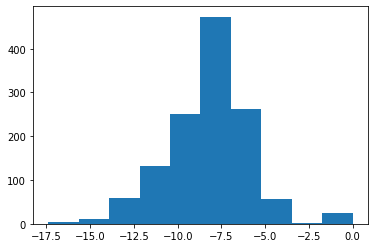

In [ ]:
if volatility_prediction:
    d_Y = np.log(d_Y ** 2)
    d_Y.replace([np.inf, -np.inf], 0, inplace=True)
plt.hist(d_Y)

In [ ]:
d_control_variables.head()

,oil_price,gas_price,stock_price,energy_price,coal_price
date,,,,,
2017-01-03,-0.024046,NaN,0.006942,NaN,NaN
2017-01-04,0.017690,0.024569,-0.001231,NaN,0.020397
2017-01-05,0.007587,0.000197,0.001040,NaN,0.018241
2017-01-06,0.003685,-0.018316,-0.000520,NaN,-0.011730
2017-01-09,-0.038562,0.041714,-0.004883,NaN,-0.008294


In [ ]:
d_control_variables.tail()

,oil_price,gas_price,stock_price,energy_price,coal_price
date,,,,,
2021-12-06,0.044775,0.005142,0.012754,0.009365,0.005745
2021-12-07,0.031783,0.058659,0.024177,0.036917,0.054928
2021-12-08,0.005024,0.064864,-0.005890,-0.002870,0.041349
2021-12-09,-0.018637,-0.016343,-0.000775,0.000183,0.002598
2021-12-10,0.009761,0.048361,-0.003002,-0.020872,0.000000


In [ ]:
control_X = control_var_preprocessing(d_Y, d_control_variables, nr_lags)

In [ ]:
control_X.head()

,const,oil_price_lag1,gas_price_lag1,stock_price_lag1,energy_price_lag1,coal_price_lag1,carbon_price_lag1,oil_price_lag2,gas_price_lag2,stock_price_lag2,energy_price_lag2,coal_price_lag2,carbon_price_lag2,oil_price_lag3,gas_price_lag3,stock_price_lag3,energy_price_lag3,coal_price_lag3,carbon_price_lag3
date,,,,,,,,,,,,,,,,,,,
2017-01-03,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1.0,-0.024046,NaN,0.006942,NaN,NaN,-4.246821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,1.0,0.017690,0.024569,-0.001231,NaN,0.020397,-5.911882,-0.024046,NaN,0.006942,NaN,NaN,-4.246821,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,1.0,0.007587,0.000197,0.001040,NaN,0.018241,-5.098236,0.017690,0.024569,-0.001231,NaN,0.020397,-5.911882,-0.024046,NaN,0.006942,NaN,NaN,-4.246821
2017-01-09,1.0,0.003685,-0.018316,-0.000520,NaN,-0.011730,-6.491988,0.007587,0.000197,0.001040,NaN,0.018241,-5.098236,0.017690,0.024569,-0.001231,NaN,0.020397,-5.911882


In [ ]:
d_Y.head()

date
2017-01-03   -4.246821
2017-01-04   -5.911882
2017-01-05   -5.098236
2017-01-06   -6.491988
2017-01-09   -6.306282
Name: carbon_price, dtype: float64

## Keyword features

In [ ]:
d_Y.shape

(1276,)

In [ ]:
# FIX MISSING DATES: TO-DO
tf_idf = tf_idf.reindex(d_Y.index)

In [ ]:
tf_idf

,ghg,climate,sustainability,sustainable,environment,ets,coal,gas,oil,crude,...,gas heating,gas turbine,fossil fuel,nuclear power,nuclear plant,nuclear energy,clean energy,green energy,emission trading system,emission trading scheme
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.0,0.691192,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
2017-01-04,0.0,0.000000,0.0,0.000000,1.417349,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
2017-01-05,0.0,0.691192,0.0,0.828745,2.246445,0.000000,1.343883,0.714420,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
2017-01-06,0.0,1.940422,0.0,0.828745,0.000000,0.000000,0.000000,0.000000,0.714866,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
2017-01-09,0.0,0.000000,0.0,0.828745,0.000000,0.000000,0.000000,0.000000,0.714866,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06,0.0,0.000000,0.0,0.000000,0.708675,0.000000,1.343883,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
2021-12-07,0.0,1.095514,0.0,0.000000,0.708675,0.000000,0.000000,0.714420,0.714866,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
2021-12-08,0.0,0.000000,0.0,0.000000,0.708675,3.062527,0.000000,1.658832,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2.51765,0.0,0.0


In [ ]:
## TF-IDF
tf_idf_X = keyword_features_preprocessing(tf_idf, d_Y,
            d_control_variables,
            nr_lags, ma_window, standardization, min_obs)

In [ ]:
tf_idf_X.head()

,const,oil_price_lag1,gas_price_lag1,stock_price_lag1,energy_price_lag1,coal_price_lag1,ghg_lag1,climate_lag1,sustainability_lag1,sustainable_lag1,...,gas turbine_lag3,fossil fuel_lag3,nuclear power_lag3,nuclear plant_lag3,nuclear energy_lag3,clean energy_lag3,green energy_lag3,emission trading system_lag3,emission trading scheme_lag3,carbon_price_lag3
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1.0,-0.024046,NaN,0.006942,NaN,NaN,-0.074925,-0.342124,-0.391739,-0.855008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,1.0,0.017690,0.024569,-0.001231,NaN,0.020397,-0.074925,-1.028249,-0.391739,-0.855008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,1.0,0.007587,0.000197,0.001040,NaN,0.018241,-0.074925,-0.342124,-0.391739,0.116315,...,-0.074349,-0.372837,-0.317149,-0.175305,-0.189309,-0.285205,-0.182533,-0.133345,-0.121006,-4.246821
2017-01-09,1.0,0.003685,-0.018316,-0.000520,NaN,-0.011730,-0.074925,0.897947,-0.391739,0.116315,...,-0.074349,-0.372837,-0.317149,-0.175305,-0.189309,-0.285205,-0.182533,-0.133345,-0.121006,-5.911882


In [ ]:
tf_idf_X.tail()

,const,oil_price_lag1,gas_price_lag1,stock_price_lag1,energy_price_lag1,coal_price_lag1,ghg_lag1,climate_lag1,sustainability_lag1,sustainable_lag1,...,gas turbine_lag3,fossil fuel_lag3,nuclear power_lag3,nuclear plant_lag3,nuclear energy_lag3,clean energy_lag3,green energy_lag3,emission trading system_lag3,emission trading scheme_lag3,carbon_price_lag3
date,,,,,,,,,,,,,,,,,,,,,
2021-12-06,1.0,0.003010,-0.056024,-0.005753,-0.021624,-0.022381,-0.074925,-1.028249,-0.391739,-0.855008,...,-0.074349,-0.372837,-0.317149,-0.175305,-0.189309,2.281337,-0.182533,-0.133345,-0.121006,-7.934488
2021-12-07,1.0,0.044775,0.005142,0.012754,0.009365,0.005745,-0.074925,-1.028249,-0.391739,-0.855008,...,-0.074349,-0.372837,-0.317149,-0.175305,-0.189309,2.281337,-0.182533,-0.133345,-0.121006,-6.491453
2021-12-08,1.0,0.031783,0.058659,0.024177,0.036917,0.054928,-0.074925,0.059233,-0.391739,-0.855008,...,-0.074349,-0.372837,2.061896,-0.175305,-0.189309,-0.285205,-0.182533,-0.133345,-0.121006,-7.787750
2021-12-09,1.0,0.005024,0.064864,-0.005890,-0.002870,0.041349,-0.074925,-1.028249,-0.391739,-0.855008,...,-0.074349,-0.372837,-0.317149,-0.175305,-0.189309,-0.285205,-0.182533,-0.133345,-0.121006,-6.560333
2021-12-10,1.0,-0.018637,-0.016343,-0.000775,0.000183,0.002598,-0.074925,-0.342124,-0.391739,-0.855008,...,-0.074349,-0.372837,-0.317149,-0.175305,-0.189309,-0.285205,-0.182533,-0.133345,-0.121006,-6.244358


## Interaction terms

In [ ]:
if interaction_terms:
    for col in tf_idf_X.columns:
        name = col + '_interaction'
        tf_idf_X[name] = tf_idf_X[col] * (tf_idf_X['carbon_price_lag1'] > 0).astype(int)
        # tf_idf_X[name] = tf_idf_X[col] * np.sign(tf_idf_X['carbon_price_lag1'])

# EDA

In [ ]:
tf_idf_X.columns

Index(['const', 'oil_price_lag1', 'gas_price_lag1', 'stock_price_lag1',
       'energy_price_lag1', 'coal_price_lag1', 'ghg_lag1', 'climate_lag1',
       'sustainability_lag1', 'sustainable_lag1',
       ...
       'gas turbine_lag3', 'fossil fuel_lag3', 'nuclear power_lag3',
       'nuclear plant_lag3', 'nuclear energy_lag3', 'clean energy_lag3',
       'green energy_lag3', 'emission trading system_lag3',
       'emission trading scheme_lag3', 'carbon_price_lag3'],
      dtype='object', length=133)

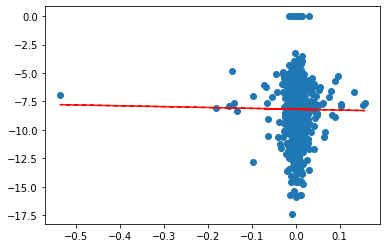

In [ ]:
eda_keyword = 'coal_price' #'climate'
eda_lag = 1
eda_x = tf_idf_X[f'{eda_keyword}_lag{eda_lag}']
eda_y = tf_idf_X[f'carbon_price_lag{eda_lag}']
plt.scatter(eda_x, eda_y)

z = np.polyfit(eda_x.fillna(0), eda_y.fillna(0), 1)
p = np.poly1d(z)
plt.plot(eda_x, p(eda_x), "r--")

plt.show()

# Regression

## Train-test split

In [ ]:
d_Y_train, d_Y_test = train_test_split(d_Y, test_window)

In [ ]:
tf_idf_X_train, tf_idf_X_test = train_test_split(tf_idf_X, test_window)

In [ ]:
tf_idf_X_test.fillna(0, inplace=True)
tf_idf_X_train.fillna(0, inplace=True)

In [ ]:
control_X_train, control_X_test = train_test_split(control_X, test_window)
control_X_test.fillna(0, inplace=True)

(array([  5.,  11.,  59., 124., 243., 456., 248.,  54.,   1.,  25.]),
 array([-17.39419031, -15.65477128, -13.91535225, -12.17593322,
        -10.43651419,  -8.69709515,  -6.95767612,  -5.21825709,
         -3.47883806,  -1.73941903,   0.        ]),
 <a list of 10 Patch objects>)

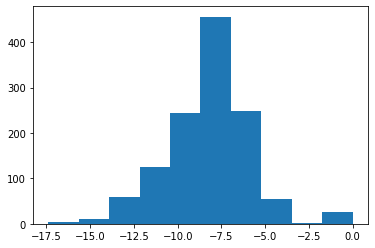

In [ ]:
plt.hist(d_Y_train)

## Control variables only

In [ ]:
control_X_train.head()

,const,oil_price_lag1,gas_price_lag1,stock_price_lag1,energy_price_lag1,coal_price_lag1,carbon_price_lag1,oil_price_lag2,gas_price_lag2,stock_price_lag2,energy_price_lag2,coal_price_lag2,carbon_price_lag2,oil_price_lag3,gas_price_lag3,stock_price_lag3,energy_price_lag3,coal_price_lag3,carbon_price_lag3
date,,,,,,,,,,,,,,,,,,,
2017-01-03,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1.0,-0.024046,NaN,0.006942,NaN,NaN,-4.246821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,1.0,0.017690,0.024569,-0.001231,NaN,0.020397,-5.911882,-0.024046,NaN,0.006942,NaN,NaN,-4.246821,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,1.0,0.007587,0.000197,0.001040,NaN,0.018241,-5.098236,0.017690,0.024569,-0.001231,NaN,0.020397,-5.911882,-0.024046,NaN,0.006942,NaN,NaN,-4.246821
2017-01-09,1.0,0.003685,-0.018316,-0.000520,NaN,-0.011730,-6.491988,0.007587,0.000197,0.001040,NaN,0.018241,-5.098236,0.017690,0.024569,-0.001231,NaN,0.020397,-5.911882


In [ ]:
control_linreg_model = sm.OLS(d_Y_train, control_X_train, missing = 'drop' )
control_linreg_model_results = control_linreg_model.fit()

In [ ]:
print(control_linreg_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:           carbon_price   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.545
Date:                Fri, 17 Jun 2022   Prob (F-statistic):           0.000400
Time:                        21:23:53   Log-Likelihood:                -2120.7
No. Observations:                 954   AIC:                             4279.
Df Residuals:                     935   BIC:                             4372.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -7.0599      0.46

In [ ]:
# Confidence intervals
import scipy.stats

confidence_level = 0.05

z = scipy.stats.norm.ppf(1 - confidence_level/2)

In [ ]:
z

1.959963984540054

In [ ]:
conf_int_df = control_linreg_model_results.params.rename('coeff').to_frame().\
              join(control_linreg_model_results.bse.rename('stderr'))

conf_int_df['ub'] = conf_int_df['coeff'] + z * conf_int_df['stderr']
conf_int_df['lb'] = conf_int_df['coeff'] - z * conf_int_df['stderr']
display(conf_int_df)

,coeff,stderr,ub,lb
const,-7.059859,0.468829,-6.140972,-7.978747
oil_price_lag1,-3.882621,2.896195,1.793816,-9.559058
gas_price_lag1,-4.626467,1.833570,-1.032737,-8.220198
stock_price_lag1,-5.843744,9.304843,12.393414,-24.080902
energy_price_lag1,-1.134954,5.785445,10.204310,-12.474218
coal_price_lag1,8.310198,4.568694,17.264673,-0.644278
carbon_price_lag1,-0.000653,0.034186,0.066350,-0.067656
oil_price_lag2,2.366266,2.907124,8.064124,-3.331593
gas_price_lag2,-4.461220,1.861052,-0.813624,-8.108815
stock_price_lag2,-3.097250,9.225644,14.984679,-21.179180


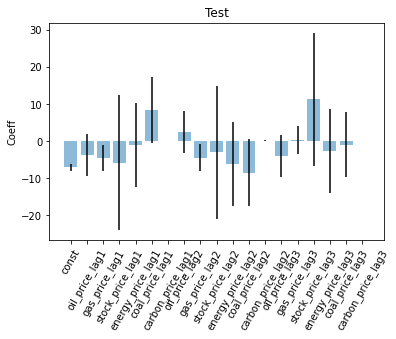

In [ ]:
plt.bar(range(len(conf_int_df.index)), conf_int_df['coeff'], 
        yerr=z * conf_int_df['stderr'], align='center', alpha=0.5)

plt.xticks(range(len(conf_int_df.index)), conf_int_df.index, rotation=60)
plt.ylabel('Coeff')
plt.title('Test')
plt.show()

## OLS

In [ ]:
tf_idf_linreg_model = sm.OLS(d_Y_train, tf_idf_X_train, missing = 'drop' )
tf_idf_linreg_results = tf_idf_linreg_model.fit()

In [ ]:
print(tf_idf_linreg_results.summary())

                            OLS Regression Results                            
Dep. Variable:           carbon_price   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.137
Date:                Fri, 17 Jun 2022   Prob (F-statistic):              0.151
Time:                        21:24:19   Log-Likelihood:                -2747.0
No. Observations:                1226   AIC:                             5760.
Df Residuals:                    1093   BIC:                             6440.
Df Model:                         132                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Stepwise selection

In [ ]:
# Python implementation taken from here (a small bug needed to be corrected)
# https://datascience.stackexchange.com/a/24447

In [ ]:
%%time
stepwise_selected_features = stepwise_selection(tf_idf_X_train.drop(columns=['const']),
                                                d_Y_train)

CPU times: user 1.9 s, sys: 13.4 ms, total: 1.92 s
Wall time: 1.91 s


In [ ]:
stepwise_model = sm.OLS(d_Y_train, tf_idf_X_train[stepwise_selected_features], missing = 'drop' )
stepwise_model_results = stepwise_model.fit()

In [ ]:
print(stepwise_model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:           carbon_price   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                              2534.
Date:                Fri, 17 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:24:44   Log-Likelihood:                         -3156.9
No. Observations:                1226   AIC:                                      6320.
Df Residuals:                    1223   BIC:                                      6335.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## PCA? (TF-IDF base)

In [ ]:
selected_cols = [i for i in control_X_train.columns if any([j in i for j in control_var_names + ['carbon_price', 'const']])]
selected_cols

['const',
 'oil_price_lag1',
 'gas_price_lag1',
 'stock_price_lag1',
 'energy_price_lag1',
 'coal_price_lag1',
 'carbon_price_lag1',
 'oil_price_lag2',
 'gas_price_lag2',
 'stock_price_lag2',
 'energy_price_lag2',
 'coal_price_lag2',
 'carbon_price_lag2',
 'oil_price_lag3',
 'gas_price_lag3',
 'stock_price_lag3',
 'energy_price_lag3',
 'coal_price_lag3',
 'carbon_price_lag3']

In [ ]:
pca = PCA(n_components=pca_components)
pca_X_train = pca.fit_transform(tf_idf_X_train.drop(columns=selected_cols).fillna(0))
pca_X_test = pca.transform(tf_idf_X_test.drop(columns=selected_cols).fillna(0))

In [ ]:
pca_X_train = pd.concat([control_X_train,
                         pd.DataFrame(pca_X_train, index=control_X_train.index,
                                      columns=[f'PCA{i + 1}' for i in range(pca_components)])], axis = 1)
pca_X_test = pd.concat([control_X_test,
                        pd.DataFrame(pca_X_test, index=control_X_test.index,
                                     columns=[f'PCA{i + 1}' for i in range(pca_components)])], axis = 1)

In [ ]:
pca_X_test.sort_index()

,const,oil_price_lag1,gas_price_lag1,stock_price_lag1,energy_price_lag1,coal_price_lag1,carbon_price_lag1,oil_price_lag2,gas_price_lag2,stock_price_lag2,energy_price_lag2,coal_price_lag2,carbon_price_lag2,oil_price_lag3,gas_price_lag3,stock_price_lag3,energy_price_lag3,coal_price_lag3,carbon_price_lag3,PCA1
date,,,,,,,,,,,,,,,,,,,,
2021-10-04,1.0,0.009633,-0.040295,-0.004208,-0.009897,0.063781,-10.658659,-0.001527,0.155067,-0.000484,-0.022341,0.047533,-8.002132,-0.005706,0.096157,0.005907,0.010405,0.030187,-8.348735,1.773542
2021-10-05,1.0,0.024668,0.018928,-0.004714,-0.028072,0.061167,-7.662313,0.009633,-0.040295,-0.004208,-0.009897,0.063781,-10.658659,-0.001527,0.155067,-0.000484,-0.022341,0.047533,-8.002132,-0.720796
2021-10-06,1.0,0.015871,0.178471,0.011601,0.009783,0.102531,-7.764306,0.024668,0.018928,-0.004714,-0.028072,0.061167,-7.662313,0.009633,-0.040295,-0.004208,-0.009897,0.063781,-10.658659,-1.027157
2021-10-07,1.0,-0.018089,-0.072155,-0.010360,-0.010873,-0.146469,-4.804789,0.015871,0.178471,0.011601,0.009783,0.102531,-7.764306,0.024668,0.018928,-0.004714,-0.028072,0.061167,-7.662313,-1.031252
2021-10-08,1.0,0.010673,-0.107781,0.015914,0.005196,-0.018947,-7.733811,-0.018089,-0.072155,-0.010360,-0.010873,-0.146469,-4.804789,0.015871,0.178471,0.011601,0.009783,0.102531,-7.764306,-1.305031
2021-10-11,1.0,0.005355,-0.099715,-0.002795,-0.023019,-0.011456,-6.740808,0.010673,-0.107781,0.015914,0.005196,-0.018947,-7.733811,-0.018089,-0.072155,-0.010360,-0.010873,-0.146469,-4.804789,0.248671
2021-10-12,1.0,0.015177,-0.025663,0.000525,0.000552,0.048790,-8.543111,0.005355,-0.099715,-0.002795,-0.023019,-0.011456,-6.740808,0.010673,-0.107781,0.015914,0.005196,-0.018947,-7.733811,2.080321
2021-10-13,1.0,-0.002753,0.002490,-0.000700,0.035754,0.006809,-11.184684,0.015177,-0.025663,0.000525,0.000552,0.048790,-8.543111,0.005355,-0.099715,-0.002795,-0.023019,-0.011456,-6.740808,2.841924
2021-10-14,1.0,-0.002881,0.082322,0.006931,0.030442,0.007376,-12.087300,-0.002753,0.002490,-0.000700,0.035754,0.006809,-11.184684,0.015177,-0.025663,0.000525,0.000552,0.048790,-8.543111,2.864366


In [ ]:
pca_tf_idf_linreg_model = sm.OLS(d_Y_train, pca_X_train, missing = 'drop' )
pca_tf_idf_linreg_results = pca_tf_idf_linreg_model.fit()

In [ ]:
print(pca_tf_idf_linreg_results.summary())

                            OLS Regression Results                            
Dep. Variable:           carbon_price   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.454
Date:                Fri, 17 Jun 2022   Prob (F-statistic):           0.000510
Time:                        21:26:25   Log-Likelihood:                -2120.3
No. Observations:                 954   AIC:                             4281.
Df Residuals:                     934   BIC:                             4378.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -7.0538      0.46

## ElasticNet

In [ ]:
elastic_net_cv = 5
elastic_net_coeff_plot_threshold = 0 #0.01

In [ ]:
%%time
elastic_net = ElasticNetCV(cv=elastic_net_cv, random_state=0, fit_intercept=False,
                            l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                            alphas=[0.001, 0.003, 0.005, 0.007, 0.009, 0.0095, 0.01])
# elastic_net = ElasticNet(alpha=0.01, random_state=0, fit_intercept=False)
elastic_net.fit(tf_idf_X_train, d_Y_train)

CPU times: user 736 ms, sys: 586 ms, total: 1.32 s
Wall time: 702 ms


In [ ]:
# Inspect best model
print(elastic_net.alpha_)
print(elastic_net.l1_ratio_)

0.01
1.0


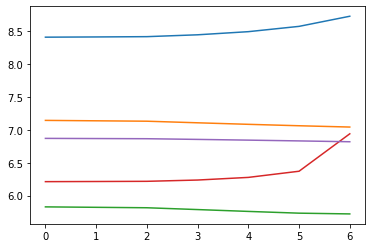

In [ ]:
plt.plot(elastic_net.mse_path_[0,:,])
plt.show()

In [ ]:
print(max(elastic_net.coef_))
print(min(elastic_net.coef_))

0.2359690249685267
-6.373467954876608


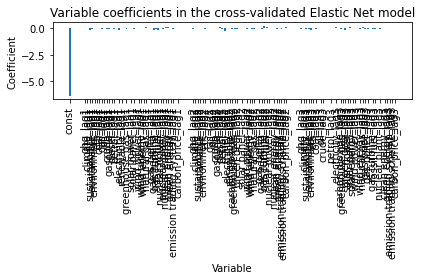

In [ ]:
plt.bar(range(len(elastic_net.coef_)), elastic_net.coef_)
selected_indexes = np.where(abs(elastic_net.coef_) > elastic_net_coeff_plot_threshold)[0]
selected_labels = tf_idf_X_train.columns[selected_indexes]
plt.title(f"Variable coefficients in the cross-validated Elastic Net model")
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.xticks(list(selected_indexes), list(selected_labels), rotation=90)
plt.tight_layout()
plt.savefig(f'./methodology_comparison/vol_elastic_net_coeffs.pdf')
plt.show()

## MLP

In [ ]:
tensorflow.random.set_seed(2)

In [ ]:
callback = EarlyStopping(patience=100, restore_best_weights=True)

In [ ]:
input = Input(shape=(tf_idf_X_train.shape[1]))
#x = Dense(128, activation='relu')(input)
#x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(input)
x = Dropout(0.2)(x)
output = Dense(1)(x)
MLP_model = keras.Model(input, output)

In [ ]:
MLP_model.compile(
    optimizer='sgd',
    #Adam(learning_rate=0.001),
    loss='mean_absolute_error')
MLP_model.fit(x=tf_idf_X_train, y=d_Y_train, batch_size=tf_idf_X_train.shape[0], validation_split=0.1, epochs=4000, shuffle=True, callbacks=[callback]
              )

Epoch 1/4000
1/1 [==============================] - 3s 3s/step - loss: 5.7721 - val_loss: 4.4845
Epoch 2/4000
1/1 [==============================] - 0s 82ms/step - loss: 3.8691 - val_loss: 2.7698
Epoch 3/4000
1/1 [==============================] - 0s 66ms/step - loss: 2.6292 - val_loss: 2.2560
Epoch 4/4000
1/1 [==============================] - 0s 67ms/step - loss: 2.4240 - val_loss: 2.2195
Epoch 5/4000
1/1 [==============================] - 0s 108ms/step - loss: 2.4638 - val_loss: 2.2141
Epoch 6/4000
1/1 [==============================] - 0s 91ms/step - loss: 2.4575 - val_loss: 2.2045
Epoch 7/4000
1/1 [==============================] - 0s 127ms/step - loss: 2.4207 - val_loss: 2.1993
Epoch 8/4000
1/1 [==============================] - 0s 106ms/step - loss: 2.4048 - val_loss: 2.2027
Epoch 9/4000
1/1 [==============================] - 0s 103ms/step - loss: 2.3741 - val_loss: 2.1925
Epoch 10/4000
1/1 [==============================] - 0s 88ms/step - loss: 2.3631 - val_loss: 2.1993
Epoch 1

# Out-of-sample prediction

We will use the MAPE metric:
$$MAPE=\frac{1}{n_{samples}}\sum_{i=0}^{n_{samples}-1}\left(\frac{|y_i-\hat{y_i}|}{max\left(\epsilon, |y_i|\right)}\right)$$

## Control variables only

In [ ]:
control_y_pred = control_linreg_model_results.predict(control_X_test)
control_y_pred.shape

(50,)

In [ ]:
control_mape = mean_absolute_percentage_error(d_Y_test, control_y_pred)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(d_Y_test, control_y_pred)

7.429330522471795

## OLS

In [ ]:
tf_idf_linreg_results.params.shape

(133,)

In [ ]:
tf_idf_y_pred = tf_idf_linreg_results.predict(tf_idf_X_test)
tf_idf_y_pred.shape

(50,)

In [ ]:
tf_idf_mape = mean_absolute_percentage_error(d_Y_test, tf_idf_y_pred)

## Stepwise selection

In [ ]:
stepwise_y_pred = stepwise_model_results.predict(tf_idf_X_test[stepwise_selected_features])
stepwise_y_pred.shape

(50,)

In [ ]:
stepwise_mape = mean_absolute_percentage_error(d_Y_test, stepwise_y_pred)

## PCA

In [ ]:
pca_tf_idf_y_pred = pca_tf_idf_linreg_results.predict(pca_X_test)
pca_tf_idf_y_pred.shape

(50,)

In [ ]:
pca_tf_idf_mape = mean_absolute_percentage_error(d_Y_test, pca_tf_idf_y_pred)

## ElasticNet

In [ ]:
elastic_net_tf_idf_y_pred = elastic_net.predict(tf_idf_X_test)
elastic_net_tf_idf_y_pred.shape

(50,)

In [ ]:
elastic_net_tf_idf_mape = mean_absolute_percentage_error(d_Y_test, elastic_net_tf_idf_y_pred)

## MLP

In [ ]:
MLP_tf_idf_y_pred = MLP_model.predict(tf_idf_X_test)
MLP_tf_idf_y_pred.shape

(50, 1)

In [ ]:
MLP_model.evaluate(tf_idf_X_test, d_Y_test)

2/2 [==============================] - 0s 6ms/step - loss: 1.8182


1.8181687593460083

In [ ]:
MLP_tf_idf_mape = mean_absolute_percentage_error(d_Y_test, MLP_tf_idf_y_pred)

# Visualize results

In [ ]:
mape_results = pd.Series({'Control': control_mape, 'OLS': tf_idf_mape,
                          'PCA': pca_tf_idf_mape,
                          'Elastic net': elastic_net_tf_idf_mape,
                          'MLP': MLP_tf_idf_mape,
                          'Stepwise': stepwise_mape})

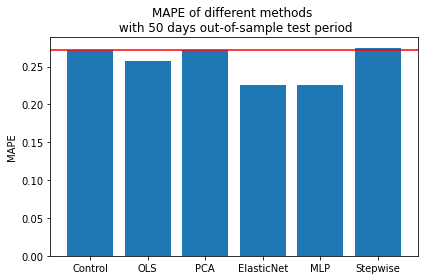

In [ ]:
plt.bar(range(len(mape_results)), mape_results, tick_label=mape_results.index)
# plt.yscale('log')
plt.axhline(mape_results['Control'], color='red')
plt.ylabel('MAPE')
plt.title(f'MAPE of different methods \n with {test_window} days out-of-sample test period')
plt.tight_layout()
plt.savefig(f'./methodology_comparison/vol_mape_results_{methodology}_{data_source}_{glossary_source}_{version}keywords_test_window_{test_window}_lags_{nr_lags}.pdf')
plt.show()

In [ ]:
mape_results

Control       0.272441
OLS           0.257620
PCA           0.271984
ElasticNet    0.225625
MLP           0.226118
Stepwise      0.274895
dtype: float64

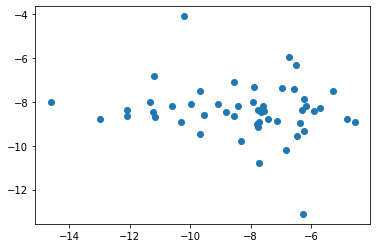

In [ ]:
plt.scatter(d_Y_test, pca_tf_idf_y_pred)
plt.show()

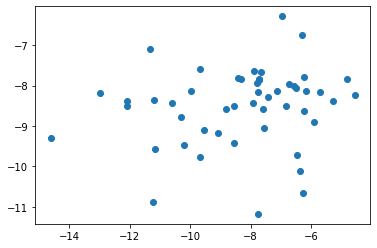

In [ ]:
plt.scatter(d_Y_test, elastic_net_tf_idf_y_pred)
plt.show()

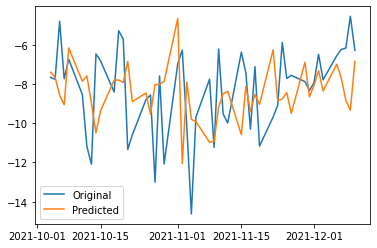

In [ ]:
plt.plot(d_Y_test, label='Original')
plt.plot(tf_idf_y_pred, label='Predicted')
plt.legend()

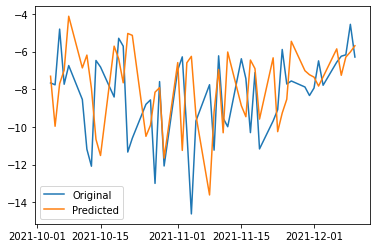

In [ ]:
plt.plot(d_Y_test, label='Original')
plt.plot(stepwise_y_pred, label='Predicted')
plt.legend()

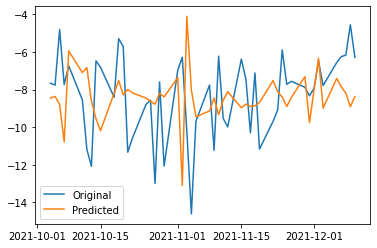

In [ ]:
plt.plot(d_Y_test, label='Original')
plt.plot(pca_tf_idf_y_pred, label='Predicted')
plt.legend()

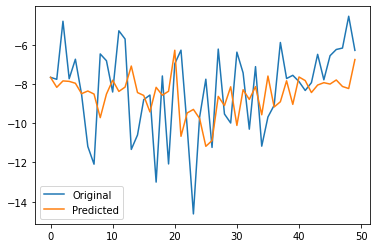

In [ ]:
plt.plot(np.array(d_Y_test), label='Original')
plt.plot(elastic_net_tf_idf_y_pred, label='Predicted')
plt.legend()

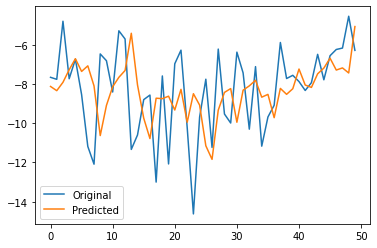

In [ ]:
plt.plot(np.array(d_Y_test), label='Original')
plt.plot(MLP_tf_idf_y_pred, label='Predicted')
plt.legend()

# Robustness checks

In [ ]:
model_types = ['control', 'ols', 'elasticnet', 'stepwise', 'pca', 'mlp']

In [ ]:
nr_lags = 3
ma_window = 1
tf_idf_ma_window = 1
covid = None #'before'
standardization = True
test_window = 50
min_obs = 1
pca_components = 1
control_var_names = ['oil_price', 'gas_price', 'stock_price',
                    'energy_price', 'coal_price']

old_keywords = False
keyword_generation = 'old' if old_keywords else 'new'

methodology = 'tf_idf' # 'tf_idf' or 'bag_of_words'
data_source = 'gdelt' # 'gdelt'
glossary_source = 'lemmatized_custom' # 'BBC' or 'IPCC' or 'custom'
version = '' # 'new' or '' for old (in case of BBC), otherwise use ''
loss_measure = 'RMSE' #'RMSE' or 'MAPE' or 'MAE' or 'MAPE (scaled)' or 'R2'
loss_measure_control_normalization = False
interaction_terms = False

In [ ]:
d_Y.shape

(1276,)

## Model types (control-only vs full data)

### Quick test with few parameters

In [ ]:
d_Y

date
2017-01-03   -4.246821
2017-01-04   -5.911882
2017-01-05   -5.098236
2017-01-06   -6.491988
2017-01-09   -6.306282
                ...   
2021-12-06   -6.560333
2021-12-07   -6.244358
2021-12-08   -6.171521
2021-12-09   -4.550648
2021-12-10   -6.289680
Name: carbon_price, Length: 1276, dtype: float64

In [ ]:
%%time
quick_lags = [2]
total_results_df = pd.DataFrame()
for measure in ['MAE', 'MAPE (scaled)']:
    robustness_results = {}
    for lag in quick_lags:
        robustness_results[lag] = {}
        for model_type in ['ols', 'elasticnet']:
            model_type_res = {}
            for tf_idf_iter in [tf_idf, None]:
                mape_val = robustness_check_workflow(tf_idf_iter, d_Y, d_control_variables, control_X,
                                                    lag, ma_window, standardization,
                                                    min_obs, test_window, model_type,
                                                    pca_components, measure)
                if tf_idf_iter is not None:
                    model_type_res['full'] = mape_val
                else:
                    model_type_res['control'] = mape_val

            robustness_results[lag][model_type] = model_type_res

    
    for lag in quick_lags:
        robustness_results_df = pd.DataFrame(robustness_results[lag]).T
        robustness_results_df['lag'] = lag
        robustness_results_df['Measure'] = measure
        robustness_results_df['Test window'] = test_window


        total_results_df = pd.concat([total_results_df, robustness_results_df])
    # csv_name = measure + '_' + str(test_window) +'test_window_' + str(min_obs) + 'minobs' + '_results_all_lags.csv'
    # total_results_df.to_csv(csv_name)

CPU times: user 1.73 s, sys: 1.43 s, total: 3.16 s
Wall time: 1.68 s


In [ ]:
total_results_df

,full,control,lag,Measure,Test window
ols,1.973229,1.975386,2,MAE,50
elasticnet,1.713217,1.805107,2,MAE,50
ols,0.254113,0.248055,2,MAPE (scaled),50
elasticnet,0.220601,0.226263,2,MAPE (scaled),50


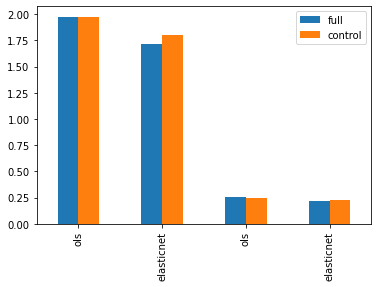

In [ ]:
total_results_df.iloc[:, :2].plot(kind='bar')

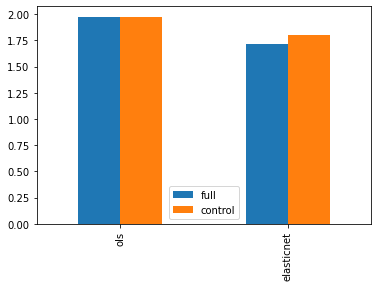

In [ ]:
total_results_df.iloc[:2, :2].plot(kind='bar')

### Full test (potential subset for COVID periods)

In [ ]:
covid

In [ ]:
covid_start_date = pd.to_datetime('2020-01-01')
if covid:
    if covid == 'before':
        d_Y_covid = d_Y[d_Y.index < covid_start_date]
        tf_idf_covid = tf_idf[tf_idf.index < covid_start_date]
        d_control_variables_covid = d_control_variables[d_control_variables.index < covid_start_date]
        control_X_covid = control_X[control_X.index < covid_start_date]
    elif covid == 'after':
        d_Y_covid = d_Y[d_Y.index >= covid_start_date]
        tf_idf_covid = tf_idf[tf_idf.index >= covid_start_date]
        d_control_variables_covid = d_control_variables[d_control_variables.index >= covid_start_date]
        control_X_covid = control_X[control_X.index >= covid_start_date]

else:
    d_Y_covid = d_Y.copy()
    tf_idf_covid = tf_idf.copy()
    d_control_variables_covid = d_control_variables.copy()
    control_X_covid = control_X.copy()

tf_idfs = [tf_idf_covid, None]
lags = [1, 2, 3]
measures = ['RMSE', 'MAE', 'MAPE (scaled)']
# model_types2 = ['ols', 'elasticnet', 'stepwise', 'pca', 'mlp'] # High runtime due to NLP
model_types = ['ols', 'elasticnet', 'pca', 'stepwise']
test_windows = [50, 75, 100]

In [ ]:
# %%time
for test_window in test_windows:
    for measure in measures:
        robustness_results = {}
        for lag in lags:
            robustness_results[lag] = {}
            for model_type in model_types:
                model_type_res = {}
                for tf_idf_iter in tf_idfs:
                    mape_val = robustness_check_workflow(tf_idf_iter, d_Y_covid, d_control_variables_covid, control_X_covid,
                                                        lag, ma_window, standardization,
                                                        min_obs, test_window, model_type,
                                                        pca_components, measure)
                    if tf_idf_iter is not None:
                        model_type_res['full'] = mape_val
                    else:
                        model_type_res['control'] = mape_val

                robustness_results[lag][model_type] = model_type_res

        total_results_df = pd.DataFrame()
        for lag in lags:
            robustness_results_df = pd.DataFrame(robustness_results[lag]).T
            robustness_results_df['lag'] = lag
            robustness_results_df['Measure'] = measure
            robustness_results_df['Test window'] = test_window


            total_results_df = pd.concat([total_results_df, robustness_results_df])
        csv_name = 'vol_' + measure + '_' + str(test_window) +'test_window_' + str(min_obs) + 'minobs' + '_results_all_lags_before_COVID.csv'
        total_results_df.to_csv(csv_name)

KeyboardInterrupt: ignored

In [ ]:
robustness_results_df = pd.DataFrame(robustness_results).T

In [ ]:
total_results_df = pd.DataFrame()
for lag in lags:
    robustness_results_df = pd.DataFrame(robustness_results[lag]).T
    robustness_results_df['lag'] = lag
    total_results_df = pd.concat([total_results_df, robustness_results_df])

In [ ]:
total_results_df

,full,control,lag
ols,3.659361e+14,3.637831e+14,1
elasticnet,3.619639e+14,3.611616e+14,1
pca,3.655730e+12,3.805288e+12,1
stepwise,2.943154e+14,2.943154e+14,1
ols,3.622860e+14,3.604501e+14,2
elasticnet,3.568136e+14,3.562361e+14,2
pca,9.731174e+12,9.667515e+12,2
stepwise,2.763147e+14,2.757303e+14,2
ols,3.550312e+14,3.603523e+14,3
elasticnet,3.591756e+14,3.624807e+14,3


In [ ]:
if loss_measure_control_normalization:
    robustness_results_df = robustness_results_df.div(robustness_results_df.control, axis=0) * 100
robustness_results_df

,full,control,lag
ols,3.550312e+14,3.603523e+14,3
elasticnet,3.591756e+14,3.624807e+14,3
pca,1.083890e+12,4.299083e+11,3
stepwise,2.763147e+14,2.757303e+14,3


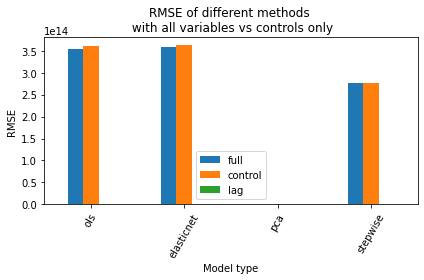

In [ ]:
robustness_results_df.plot(kind='bar')
#plt.yscale('log')
plt.ylabel(loss_measure)
plt.xlabel('Model type')
plt.xticks(rotation=60)
plt.title(f'{loss_measure} of different methods \n with all variables vs controls only')
plt.legend()
plt.tight_layout()
plt.savefig(f'./methodology_comparison/vol_' + '{loss_measure}_results_control_vs_full_robustness_{methodology}_{data_source}_{glossary_source}_{version}keywords_lags_{nr_lags}.pdf')
plt.show()

In [ ]:
robustness_results_df

,full,control,lag
ols,3.550312e+14,3.603523e+14,3
elasticnet,3.591756e+14,3.624807e+14,3
pca,1.083890e+12,4.299083e+11,3
stepwise,2.763147e+14,2.757303e+14,3


### Visualization

In [17]:
lags = [1, 2, 3]
measures = ['RMSE', 'MAE', 'MAPE (scaled)']
# model_types = ['ols', 'elasticnet', 'pca', 'stepwise']
model_types = ['ols', 'elasticnet']
test_windows = [50, 75, 100]

min_obs = 1

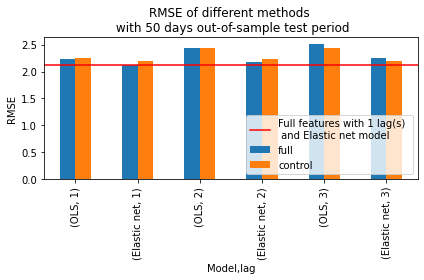

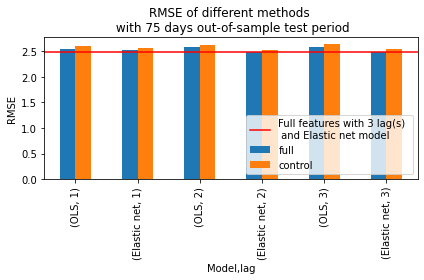

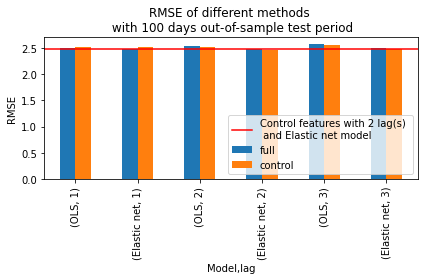

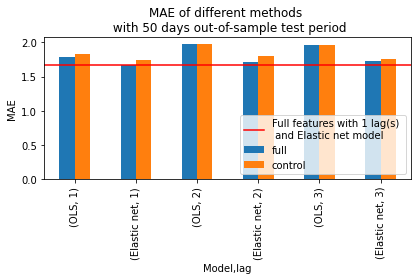

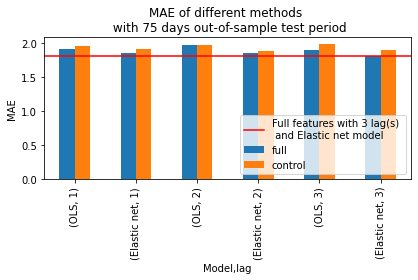

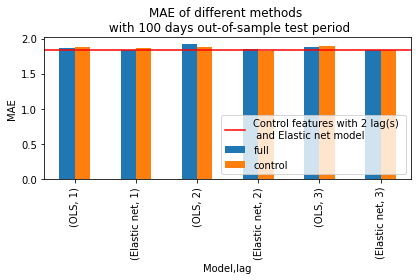

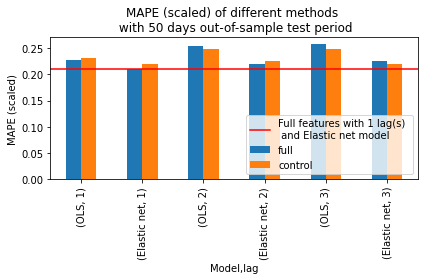

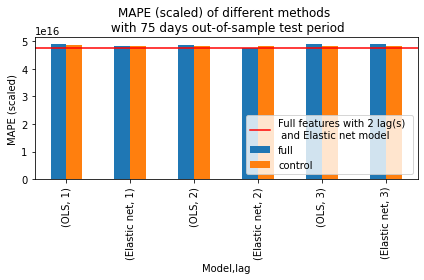

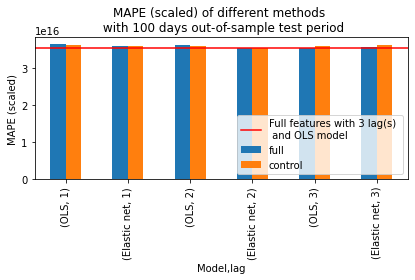

In [36]:
for measure in measures:
    for test_window in test_windows:
        csv_name = 'vol_' + measure + '_' + str(test_window) +'test_window_' + \
                str(min_obs) + 'minobs' + '_results_all_lags_before_COVID.csv'

        df = pd.read_csv(csv_name, index_col=0)
        df = df[df.index.isin(model_types)]
        df.index = df.index.map({'ols': 'OLS',
                                 'elasticnet': 'Elastic net',
                                 'pca': 'PCA',
                                 'mlp': 'MLP',
                                 'stepwise': 'Stepwise',})
        df.index.name = 'Model'
        df = df.set_index([df.index, 'lag'])

        control_min = np.min(df[['control']].values)
        full_min = np.min(df[['full']].values)
        if full_min <= control_min:
            minim = full_min
            model, lag = df[df['full'] == full_min].index[0]
            minim_label = 'Full features' + f' with {str(lag)} lag(s) \n and {str(model)} model'
        else:
            minim = full_min
            model, lag = df[df['control'] == control_min].index[0]
            minim_label = 'Control features' + f' with {str(lag)} lag(s) \n and {str(model)} model' 

        df[['full', 'control']].plot(kind='bar')
        plt.axhline(minim, color='red',
                    label=minim_label)
        plt.ylabel(measure)
        plt.title(f'{measure} of different methods \n with {test_window} days out-of-sample test period')
        plt.tight_layout()
        plt.legend(loc='lower right')
        plt.savefig(f'./methodology_comparison/vol_{measure}_test_window_{test_window}_model_robustness_results_{methodology}_{data_source}_{glossary_source}_{version}keywords.pdf')
        plt.show()

## Test window size

In [ ]:
test_windows = [50, 100, 150]
robustness_results = {}

In [ ]:
for model_type in model_types:
    model_type_res = {}
    for test_window in test_windows:
        mape_val = robustness_check_workflow(tf_idf, d_Y, d_control_variables, control_X,
                                             nr_lags, ma_window, standardization,
                                             min_obs, test_window, model_type,
                                             pca_components)
        
        model_type_res[test_window] = mape_val

    robustness_results[model_type] = model_type_res

In [ ]:
robustness_results_df = pd.DataFrame(robustness_results)
robustness_results_df.head()

,ols,elasticnet,pca
50,2.420926e-01,2.200772e-01,9.959717e-01
100,3.590075e+14,3.542218e+14,9.704513e+12
150,2.405005e+14,2.367783e+14,6.008154e+12


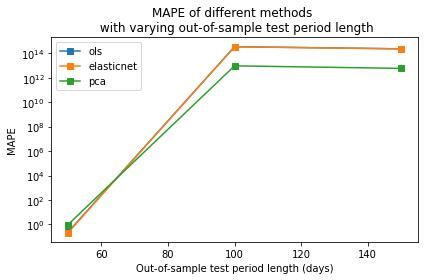

In [ ]:
for col in robustness_results_df.columns:
    plt.plot(robustness_results_df[col], label=col, marker='s')
plt.yscale('log')
plt.ylabel('MAPE')
plt.xlabel('Out-of-sample test period length (days)')
plt.title(f'MAPE of different methods \n with varying out-of-sample test period length')
plt.legend()
plt.tight_layout()
plt.savefig(f'./methodology_comparison/vol_mape_results_window_size_robustness_{methodology}_{data_source}_{glossary_source}_{version}keywords_lags_{nr_lags}.pdf')
plt.show()

## Number of lags

In [ ]:
nrs_lags = [1, 3, 5, 10]
robustness_results = {}

In [ ]:
for model_type in model_types:
    model_type_res = {}
    for nr_lags in nrs_lags:
        mape_val = robustness_check_workflow(tf_idf, d_Y, d_control_variables, control_X,
                                             nr_lags, ma_window, standardization,
                                             min_obs, test_window, model_type,
                                             pca_components)
        
        model_type_res[nr_lags] = mape_val

    robustness_results[model_type] = model_type_res

In [ ]:
robustness_results_df = pd.DataFrame(robustness_results)
robustness_results_df.head()

,ols,elasticnet,pca
1,2.408132e+14,2.397418e+14,2.311536e+12
3,2.377939e+14,2.382644e+14,1.182943e+11
5,2.488322e+14,2.504613e+14,7.415954e+12
10,2.487812e+14,2.516092e+14,6.612650e+12


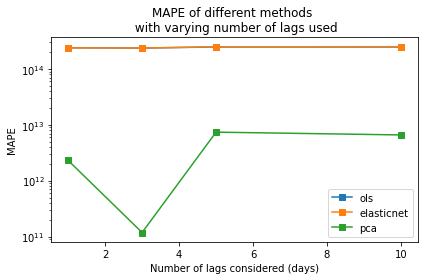

In [ ]:
for col in robustness_results_df.columns:
    plt.plot(robustness_results_df[col], label=col, marker='s')
plt.yscale('log')
plt.ylabel('MAPE')
plt.xlabel('Number of lags considered (days)')
plt.title(f'MAPE of different methods \n with varying number of lags used')
plt.legend()
plt.tight_layout()
plt.savefig(f'./methodology_comparison/vol_mape_results_number_of_lags_robustness_{methodology}_{data_source}_{glossary_source}_{version}keywords_test_window_{test_window}.pdf')
plt.show()

# Export results

In [ ]:
# rmse, mape, mae

In [ ]:
mape_results.index.name = 'Method name'
mape_results.name = 'MAPE'
#mape_results.to_csv(f'./methodology_comparison/mape_results_{methodology}_{data_source}_{glossary_source}_{version}keywords_test_window_{test_window}_lags_{nr_lags}.csv')

# Support

In [ ]:
y_true = np.random.normal(size=5)
y_pred = np.random.normal(size=5)

In [ ]:
# MAPE metric as described here: https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error
mean_absolute_percentage_error(y_true, y_pred)

# Lag visualization

In [ ]:
rsquares = {}
mapes = {}
rmses = {}
from sklearn.metrics import mean_squared_error

for lag in range(1,20):
    tf_idf_X = keyword_features_preprocessing(tf_idf, d_Y, None, lag , ma_window, standardization, min_obs=0, concat_all=False)
    tf_idf_X_train, tf_idf_X_test = train_test_split(tf_idf_X, test_window)
    tf_idf_X_test.fillna(0, inplace=True)
    d_Y_train, d_Y_test = train_test_split(d_Y, test_window)
    model = sm.OLS(d_Y_train, tf_idf_X_train, missing = 'drop' )
    results = model.fit()
    y_pred = results.predict(tf_idf_X_test)
    mape = mean_absolute_percentage_error(d_Y_test, y_pred)
    rmse = mean_squared_error(d_Y_test, y_pred, squared=True)
    rsquares[lag] = results.rsquared
    rmses[lag] = rmse
    mapes[lag] = mape
    

In [ ]:
rsquares = {}
mapes = {}
rmses = {}
for lag in range(1,10):
    tf_idf_X = control_var_preprocessing(d_Y, d_control_variables, lag, concat_all=False)
    tf_idf_X_train, tf_idf_X_test = train_test_split(tf_idf_X, test_window)
    d_Y_train, d_Y_test = train_test_split(d_Y, test_window)
    tf_idf_X_test.fillna(0, inplace=True)
    model = sm.OLS(d_Y_train, tf_idf_X_train, missing = 'drop' )
    results = model.fit()
    y_pred = results.predict(tf_idf_X_test)
    mape = mean_absolute_percentage_error(d_Y_test, y_pred)
    rmse = mean_squared_error(d_Y_test, y_pred, squared=True)
    rsquares[lag] = results.rsquared
    rmses[lag] = rmse
    mapes[lag] = mape

In [ ]:
#names, counts = zip(*rsquares.items())
#names, counts = zip(*mapes.items())
names, counts = zip(*rmses.items())

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(names, counts, marker="s")
plt.xticks(names)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(names, counts, marker="s")
plt.xticks(names)

# PCA regression

PCA analysis is most detailed in the *TF-IDF regression.ipynb* notebook, the following code snippets are mainly taken from there, for any additional ideas/details (e.g. Wald-test etc), check that notebook!

In [ ]:
pca_components = 2 #10 # to find out how many components to use based on the explained variance plot! 
only_keyword_pca = True

## Full sample

In [ ]:
control_X.columns

Index(['const', 'oil_price_lag1', 'gas_price_lag1', 'stock_price_lag1',
       'energy_price_lag1', 'coal_price_lag1', 'carbon_price_lag1',
       'oil_price_lag2', 'gas_price_lag2', 'stock_price_lag2',
       'energy_price_lag2', 'coal_price_lag2', 'carbon_price_lag2',
       'oil_price_lag3', 'gas_price_lag3', 'stock_price_lag3',
       'energy_price_lag3', 'coal_price_lag3', 'carbon_price_lag3',
       'oil_price_lag4', 'gas_price_lag4', 'stock_price_lag4',
       'energy_price_lag4', 'coal_price_lag4', 'carbon_price_lag4',
       'oil_price_lag5', 'gas_price_lag5', 'stock_price_lag5',
       'energy_price_lag5', 'coal_price_lag5', 'carbon_price_lag5',
       'oil_price_lag6', 'gas_price_lag6', 'stock_price_lag6',
       'energy_price_lag6', 'coal_price_lag6', 'carbon_price_lag6',
       'oil_price_lag7', 'gas_price_lag7', 'stock_price_lag7',
       'energy_price_lag7', 'coal_price_lag7', 'carbon_price_lag7',
       'oil_price_lag8', 'gas_price_lag8', 'stock_price_lag8',
       'ene

In [ ]:
selected_cols = [i for i in control_X.columns if any([j in i for j
                                                            in control_var_names + ['carbon_price', 'const']])]
# selected_cols

In [ ]:
pca = PCA(n_components=pca_components)

if only_keyword_pca:
    pca_X = pca.fit_transform(tf_idf_X.drop(columns=selected_cols).fillna(0))
    pca_X = pd.concat([control_X,
                         pd.DataFrame(pca_X, index=control_X.index,
                                      columns=[f'PCA{i + 1}' for i in range(pca_components)])], axis = 1)
    all_cols = tf_idf_X.drop(columns=selected_cols).columns
else:
    # pca_X = pca.fit_transform(tf_idf_X.fillna(0))
    # all_cols = tf_idf_X.columns
    pca_X = pca.fit_transform(control_X.fillna(0))
    all_cols = control_X.columns

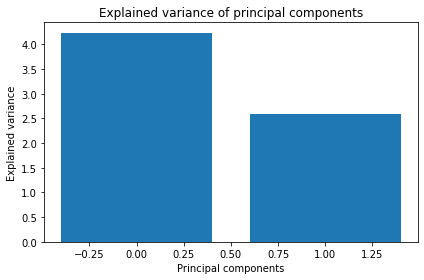

In [ ]:
plt.bar(range(pca.components_.shape[0]), pca.explained_variance_)
plt.title(f"Explained variance of principal components")
plt.xlabel("Principal components")
plt.ylabel("Explained variance")
plt.tight_layout()
plt.savefig(f'./methodology_comparison/pca_explained_variance_tf_idf.pdf')
plt.show()

In [ ]:
pca_X.columns

Index(['const', 'oil_price_lag1', 'gas_price_lag1', 'stock_price_lag1',
       'energy_price_lag1', 'coal_price_lag1', 'carbon_price_lag1',
       'oil_price_lag2', 'gas_price_lag2', 'stock_price_lag2',
       'energy_price_lag2', 'coal_price_lag2', 'carbon_price_lag2',
       'oil_price_lag3', 'gas_price_lag3', 'stock_price_lag3',
       'energy_price_lag3', 'coal_price_lag3', 'carbon_price_lag3',
       'oil_price_lag4', 'gas_price_lag4', 'stock_price_lag4',
       'energy_price_lag4', 'coal_price_lag4', 'carbon_price_lag4',
       'oil_price_lag5', 'gas_price_lag5', 'stock_price_lag5',
       'energy_price_lag5', 'coal_price_lag5', 'carbon_price_lag5',
       'oil_price_lag6', 'gas_price_lag6', 'stock_price_lag6',
       'energy_price_lag6', 'coal_price_lag6', 'carbon_price_lag6',
       'oil_price_lag7', 'gas_price_lag7', 'stock_price_lag7',
       'energy_price_lag7', 'coal_price_lag7', 'carbon_price_lag7',
       'oil_price_lag8', 'gas_price_lag8', 'stock_price_lag8',
       'ene

### Stepwise check

In [ ]:
%%time
pca_stepwise_selected_features = stepwise_selection(pca_X.drop(columns=['const']),
                                                d_Y)

CPU times: user 593 ms, sys: 0 ns, total: 593 ms
Wall time: 591 ms


In [ ]:
pca_stepwise_selected_features # PCA variables are not getting picked by stepwsie unfortunately

['carbon_price_lag2', 'carbon_price_lag6']

In [ ]:
pca_tf_idf_linreg_model = sm.OLS(d_Y, pca_X, missing = 'drop' )
pca_tf_idf_linreg_results = pca_tf_idf_linreg_model.fit()

In [ ]:
print(pca_tf_idf_linreg_results.summary())

                            OLS Regression Results                            
Dep. Variable:           carbon_price   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.625
Date:                Fri, 17 Jun 2022   Prob (F-statistic):            0.00472
Time:                        21:15:10   Log-Likelihood:                -1977.0
No. Observations:                 904   AIC:                             4056.
Df Residuals:                     853   BIC:                             4301.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.1844      0.69

### Loadings

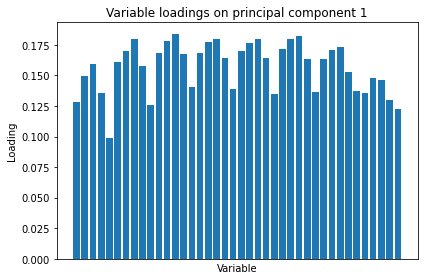

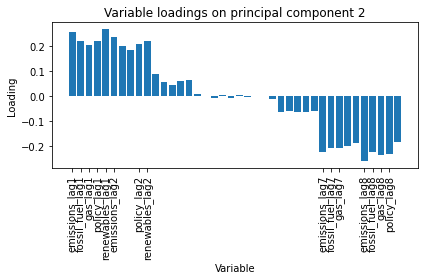

In [ ]:
for i in range(pca.components_.shape[0]):
    plt.bar(range(pca.components_.shape[1]), pca.components_[i,:])
    selected_indexes = np.where(abs(pca.components_[i,:]) > 0.2)[0]
    selected_labels = all_cols[selected_indexes]
    plt.title(f"Variable loadings on principal component {i+1}")
    plt.xlabel("Variable")
    plt.ylabel("Loading")
    plt.xticks(list(selected_indexes), list(selected_labels), rotation=90)
    plt.tight_layout()
    plt.savefig(f'./methodology_comparison/pca{i+1}_loadings_tf_idf.pdf')
    plt.show()

### pcLasso

In [ ]:
display(tf_idf_X.fillna(0))

In [ ]:
tf_idf_X.head()

In [ ]:
# Export variables to be used in R notebook for PCLASSO
tf_idf_X.fillna(0).to_csv('./methodology_comparison/tf_idf_X.csv')
d_Y.fillna(0).to_csv('./methodology_comparison/d_Y.csv')

## Pre-COVID

In [ ]:
covid_start_date = pd.to_datetime('2020-01-01')

In [ ]:
d_Y_pre_covid = d_Y[d_Y.index < covid_start_date]

## Post-COVID

In [ ]:
d_Y_post_covid = d_Y[d_Y.index >= covid_start_date]

In [ ]:
d_Y_post_covid

# Quantile regression

Note that the quantile regression implementation of *sklearn* is really slow (even though it is a linear program).

In [ ]:
from sklearn.linear_model import QuantileRegressor

In [ ]:
tf_idf_X.columns

In [ ]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
subset_size = 100

In [ ]:
%%time
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(tf_idf_X.fillna(0).iloc[:subset_size], d_Y.iloc[:subset_size]) \
            .predict(tf_idf_X.fillna(0).iloc[:subset_size])
    predictions[quantile] = y_pred

In [ ]:
for quantile, y_pred in predictions.items():
    plt.hist(y_pred, label=f"Quantile: {quantile} prediction")

plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
var_to_plot = ['carbon_lag1']
X = tf_idf_X[var_to_plot]

In [ ]:
%%time
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X.fillna(0).iloc[:subset_size], d_Y.iloc[:subset_size]) \
            .predict(X.fillna(0).iloc[:subset_size])
    predictions[quantile] = y_pred

In [ ]:
plt.scatter(X.iloc[:subset_size], d_Y.iloc[:subset_size],
            color="black", label="True values")

for quantile, y_pred in predictions.items():
    plt.plot(X.iloc[:subset_size], y_pred[:subset_size],
             label=f"Quantile: {quantile} prediction")

plt.xlabel(var_to_plot[0])
plt.ylabel("Target value")
plt.legend()
plt.show()

# Stepwise - Covid split

In [ ]:
def stepwise_split_workflow(x, y, covid=None):
    for lag in range(8,9):
        tf_idf_X_lag = keyword_features_preprocessing(x, y,
                d_control_variables,
                lag, ma_window, standardization, min_obs)
        selected_variables = stepwise_selection(tf_idf_X_lag, y)
        y_mod = y.copy()

        covid_start_date = pd.to_datetime('2020-01-01')
        if covid:
            if covid == 'before':
                y_mod = y[y.index < covid_start_date]
                tf_idf_X_lag = tf_idf_X_lag[tf_idf_X_lag.index < covid_start_date]
            elif covid == 'after':
                y_mod = y[y.index >= covid_start_date]
                tf_idf_X_lag = tf_idf_X_lag[tf_idf_X_lag.index >= covid_start_date]

        filtered_predictors = tf_idf_X_lag[selected_variables]
        linreg_model = sm.OLS(y_mod, filtered_predictors, missing='drop')
        linreg_results = linreg_model.fit()
        print(f'------- LAG {lag} -------')
        print(linreg_results.params)
        print()

## Full sample

In [ ]:
stepwise_split_workflow(tf_idf, d_Y)

In [ ]:
stepwise_split_workflow(tf_idf, d_Y, covid='before')

In [ ]:
stepwise_split_workflow(tf_idf, d_Y, covid='after')

In [ ]:
stepwise_split_workflow(tf_idf, d_Y)

## Pre-COVID

In [ ]:
stepwise_split_workflow(tf_idf, d_Y, covid='before')

## Post-COVID

In [ ]:
stepwise_split_workflow(tf_idf, d_Y, covid='after')

## Compare

In [ ]:
# FULL

# photovoltaic_lag4           1.839563e-13
# hydropower_lag1             3.859706e-09
# carbon_price_lag1           2.076503e-14
# oil_price_lag1              1.457747e-03
# carbon_price_lag5           1.965675e-09
# oil_price_lag2              3.558687e-06
# carbon_price_lag4           1.174668e-07
# carbon_price_lag6           1.019865e-06
# carbon_price_lag7           1.290945e-06
# carbon_price_lag3           5.894535e-06
#  nox _lag3                  3.506586e-04
#  coal _lag7                 1.457765e-03
# hydroelectric power_lag7    2.362855e-03
# wind turbines_lag2          6.850251e-03
# forestation_lag4            1.027153e-02

In [ ]:
# BEFORE COVID

# photovoltaic_lag4           1.305378e-13
# hydropower_lag1             2.257749e-09
# carbon_price_lag1           6.780981e-06
# oil_price_lag1              9.051111e-01
# carbon_price_lag5           6.878988e-09
# oil_price_lag2              8.745709e-02
# carbon_price_lag4           8.412416e-05
# carbon_price_lag6           2.879722e-03
# carbon_price_lag7           6.664641e-04
# carbon_price_lag3           1.800016e-05
#  nox _lag3                  1.485187e-04
#  coal _lag7                 7.044204e-04
# hydroelectric power_lag7    8.357876e-01
# wind turbines_lag2          9.387842e-06
# forestation_lag4            1.215629e-03

In [ ]:
# AFTER COVID

# photovoltaic_lag4           7.714291e-01
# hydropower_lag1             7.141538e-02
# carbon_price_lag1           3.812324e-11
# oil_price_lag1              4.151719e-05
# carbon_price_lag5           4.154231e-02
# oil_price_lag2              2.257496e-05
# carbon_price_lag4           9.627060e-04
# carbon_price_lag6           1.899497e-04
# carbon_price_lag7           5.708245e-05
# carbon_price_lag3           1.892807e-02
#  nox _lag3                  4.425322e-01
#  coal _lag7                 4.542136e-01
# hydroelectric power_lag7    2.113351e-03
# wind turbines_lag2          1.049379e-01
# forestation_lag4            7.473998e-01

# Coeffs by time

In [ ]:
selected_variables = ['photovoltaic_lag4', 'hydropower_lag1','carbon_price_lag1','oil_price_lag1',
                       'carbon_price_lag5','oil_price_lag2','carbon_price_lag4','carbon_price_lag6',
                       'carbon_price_lag7','carbon_price_lag3',' nox _lag3',' coal _lag7',
                       'hydroelectric power_lag7','wind turbines_lag2','forestation_lag4']


In [ ]:
filtered_tf_idf_X = tf_idf_X[selected_variables]

In [ ]:
coeff_results_df = pd.DataFrame(index=selected_variables)
stderr_results_df = pd.DataFrame(index=selected_variables)

for day in range(len(filtered_tf_idf_X)):
    try:
        linreg_model = sm.OLS(d_Y[:day], filtered_tf_idf_X[:day], missing='drop')
        linreg_results = linreg_model.fit()
        coeff = linreg_results.params
        stderror = linreg_results.bse

        coeff_results_df[f'coeff_day{day}'] = coeff
        stderr_results_df[f'stderr_day{day}'] = stderror
    except:
        pass

In [ ]:
x = d_Y[nr_lags:].index

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(x[100:], coeff_results_df.T[100:])

In [ ]:
fig, axs = plt.subplots(coeff_results_df.shape[0], figsize=(10,60))
for i, (ind, keyword) in enumerate(coeff_results_df.iterrows()):
    axs[i].plot(x[100:], keyword[100:])
    axs[i].title.set_text(ind)
    axs[i].axhline(0, color='red')

## Window

In [ ]:
window_size = 200

In [ ]:
w_coeff_results_df = pd.DataFrame(index=selected_variables)
w_stderr_results_df = pd.DataFrame(index=selected_variables)

for day in range(len(filtered_tf_idf_X) - window_size):
    try:
        linreg_model = sm.OLS(d_Y[day:window_size + day], filtered_tf_idf_X[day:window_size + day], missing='drop')
        linreg_results = linreg_model.fit()
        coeff = linreg_results.params
        stderror = linreg_results.bse

        w_coeff_results_df[f'coeff_day{day}'] = coeff
        w_stderr_results_df[f'stderr_day{day}'] = stderror
    except:
        pass

In [ ]:
x = d_Y.index[:-window_size]

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(x, w_coeff_results_df.T)

In [ ]:
fig, axs = plt.subplots(w_coeff_results_df.shape[0], figsize=(10,60))
for i, (ind, keyword) in enumerate(w_coeff_results_df.iterrows()):
    axs[i].plot(x, keyword)
    axs[i].title.set_text(ind)
    axs[i].axhline(0, color='red')